step1. import library

In [1]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, iirnotch
import matplotlib.pyplot as plt
from google.colab import drive
import glob
import os
import time
import tensorflow as tf
from tensorflow import keras
from scipy.signal import butter, filtfilt, stft
from scipy.signal import butter, lfilter, iirnotch



step2. train, test 데이터 불러오기 (.csv file)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 1. 경로 설정
train_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data/'
all_train_files = glob.glob(train_folder_path + 'sEMG_data_*.csv')
all_train_files.sort()  # 리스트 정렬


test_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data_test/'
all_test_files = glob.glob(test_folder_path + 'sEMG_data_*.csv')
all_test_files.sort()   # 리스트 정렬


# 2. 개수 확인
print(f'Total train data files: {len(all_train_files)}')
print(f'Total test data files: {len(all_test_files)}')



Total train data files: 26
Total test data files: 2


step3. Filtering (Butter_bandpass + Notch filter)

In [4]:
# function for filtering
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Butterworth Bandpass Filter 설계
    """
    nyq = 0.5 * fs  # Nyquist Frequency (샘플링 레이트의 절반)
    low = lowcut / nyq
    high = highcut / nyq

    # [주의] high가 1.0 이상이면 에러가 발생하므로 1.0보다 작게 클리핑
    if high >= 1.0:
        high = 0.99

    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_semg_filters(data_array, fs=200):
    """
    입력된 데이터 배열(1D)에 Bandpass 및 Notch 필터 적용
    - Bandpass: 20 ~ 95 Hz (sEMG 유효 주파수 대역)
    - Notch: 60 Hz (전원 노이즈 제거)
    """
    # 1. Bandpass Filter 적용
    b_band, a_band = butter_bandpass(20, 95, fs, order=4)
    filtered_data = lfilter(b_band, a_band, data_array)

    # 2. Notch Filter 적용 (60Hz 제거, Q factor=30) -- 전원의 노이즈를 제거해보자~ # 졸리당
    b_notch, a_notch = iirnotch(w0=60, Q=30, fs=fs)
    filtered_data = lfilter(b_notch, a_notch, filtered_data)

    return filtered_data

# 센서 이탈 감지 함수
def get_flatline_mask(series, window_size=20):
    """
    값이 거의 변하지 않거나(std=0) 너무 작은(<=6) 구간을 찾습니다.
    window_size=20은 약 0.1초 (200Hz 기준)
    """
    # rolling std가 NaN이면(앞부분) 0으로 채움
    is_flat = series.rolling(window=window_size).std().fillna(0) == 0
    is_small = series <= 6
    return is_flat | is_small


def process_and_filter_files(file_list, purpose="Train"):
    processed_list = []
    print(f"--- Processing {purpose} Files ({len(file_list)} files) ---")

    for idx, f_path in enumerate(file_list):
        try:
            # CSV 읽기
            df = pd.read_csv(f_path)

            # 필터링된 데이터를 담을 빈 DataFrame 생성 (구조 복사)
            df_filtered = df.copy()

            # 각 채널별로 필터링 수행
            for ch in target_channels:
                raw_signal = df[ch].values

                # 필터 함수 호출
                filtered_signal = apply_semg_filters(raw_signal, fs=200)

                bad_mask = get_flatline_mask(df[ch], window_size=40) #  원본 데이터에서 센서 이탈 구간 찾기

                filtered_signal[bad_mask] = 0.0 # 필터링된 신호에 마스크(=0) 적용

                df_filtered[ch] = filtered_signal

            # 결과 저장 (Filtered DataFrame과 라벨값 시리즈를 튜플로 저장하거나, 그냥 df째로 저장)
            processed_list.append(df_filtered)


            # (진행상황 출력) 첫 파일과 10번째 파일마다 출력
            if idx == 0 or (idx + 1) % 10 == 0:
                print(f"[{idx+1}/{len(file_list)}] Filtering Completed: {f_path.split('/')[-1]}")

        except Exception as e:
            print(f"Error processing {f_path}: {e}")

    return processed_list

In [5]:
# 데이터 로드 및 필터링 적용 예시

# 나중에 학습 데이터 모을 리스트
train_data_list = []  # [(df_filtered, label), (df_filtered, label), ...]
test_data_list = []

target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']


# 함수 실행 (Train / Test 각각 수행)
train_dfs = process_and_filter_files(all_train_files, purpose="Train")
test_dfs = process_and_filter_files(all_test_files, purpose="Test")

--- Processing Train Files (26 files) ---
[1/26] Filtering Completed: sEMG_data_0.csv
[10/26] Filtering Completed: sEMG_data_17.csv
[20/26] Filtering Completed: sEMG_data_3.csv
--- Processing Test Files (2 files) ---
[1/2] Filtering Completed: sEMG_data_26.csv


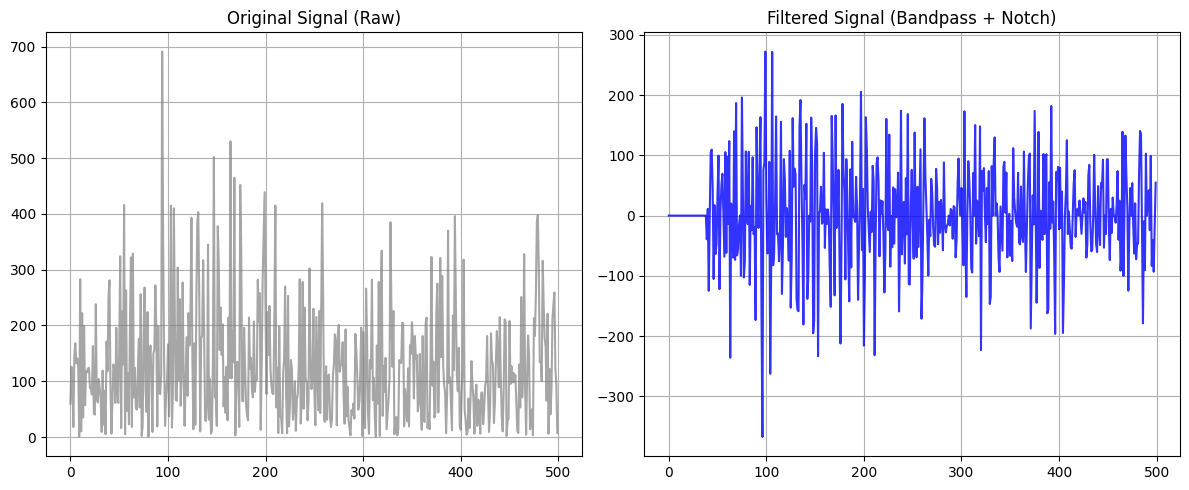

필터링 적용 완료! 데이터가 메모리(train_dfs, test_dfs)에 저장되었습니다.


In [6]:
# 3. (확인용) 필터링 전후 비교 Plot
# 첫 번째 파일의 첫 번째 채널을 예시로 시각화
if len(train_dfs) > 0:
    original_df = pd.read_csv(all_train_files[0])
    filtered_df = train_dfs[0]

    plt.figure(figsize=(12, 5))

    # 원본 신호 (일부 구간만 확대해서 보기, 예: 0~500 샘플)
    plt.subplot(1, 2, 1)
    plt.plot(original_df['Ch1'][:500], label='Original', color='gray', alpha=0.7)
    plt.title("Original Signal (Raw)")
    plt.grid(True)

    # 필터링 신호
    plt.subplot(1, 2, 2)
    plt.plot(filtered_df['Ch1'][:500], label='Filtered', color='blue', alpha=0.8)
    plt.title("Filtered Signal (Bandpass + Notch)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("필터링 적용 완료! 데이터가 메모리(train_dfs, test_dfs)에 저장되었습니다.")

step4. Normalization (MVC, MinMax, Zscore)

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Train 데이터의 모든 값을 한 줄로 모으는 코드 (Scaler 학습용)
target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
all_train_values = np.concatenate([df[target_channels].values for df in train_dfs])

# 3가지 normalization option

SCALER_TYPE = 'MVC'  # <-- 'MVC' or 'MinMax' or 'Zscore'

print(f"step4. normalization , Selected Method: {SCALER_TYPE})...")

# 학습용 데이터 전체 값 모으기 (통계량 계산용)
target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
all_train_values = np.concatenate([df[target_channels].values for df in train_dfs])


step4. normalization , Selected Method: MVC)...


In [8]:
# 1) Z-score Scaling (Standardization)
if SCALER_TYPE == 'Zscore':
    scaler = StandardScaler()
    scaler.fit(all_train_values)

    def apply_normalization(data_values, scaler_obj):
        return scaler_obj.transform(data_values)

# 2) Min-Max Scaling
elif SCALER_TYPE == 'MinMax':
    # sEMG는 음수 값도 중요하므로 (-1, 1) 범위로 설정하는 것이 좋음
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(all_train_values)

    def apply_normalization(data_values, scaler_obj):
        return scaler_obj.transform(data_values)


# 3) MVC (Maximum Voluntary Contraction) Scaling
# (Train 데이터 전체에서 가장 컸던 절대값을 MVC로 간주)
# 각 채널별 최대값(절대값 기준) 계산

elif SCALER_TYPE == 'MVC':

    mvc_values = np.max(np.abs(all_train_values), axis=0)

    # 분모가 0이 되는 것을 방지 (아주 작은 값 더해줌)
    mvc_values = mvc_values + 1e-8

    print(f"  -> Computed MVC (Max Abs) per channel: {mvc_values}")

    # Scaler 객체 대신 MVC 값 자체를 저장 (Dummy 객체처럼 취급)
    scaler = mvc_values

    def apply_normalization(data_values, scaler_obj):
        # 공식: Data / MVC
        # (음수/양수 유지를 위해 값 자체를 나눔)
        return data_values / scaler_obj

else:
    raise ValueError("SCALER_TYPE을 확인하세요! ('MVC', 'MinMax', 'Zscore')")

print(" -> Scaler 학습(준비) 완료.")

  -> Computed MVC (Max Abs) per channel: [ 857.99082257  909.31248194 1125.02506202 1036.5581655 ]
 -> Scaler 학습(준비) 완료.


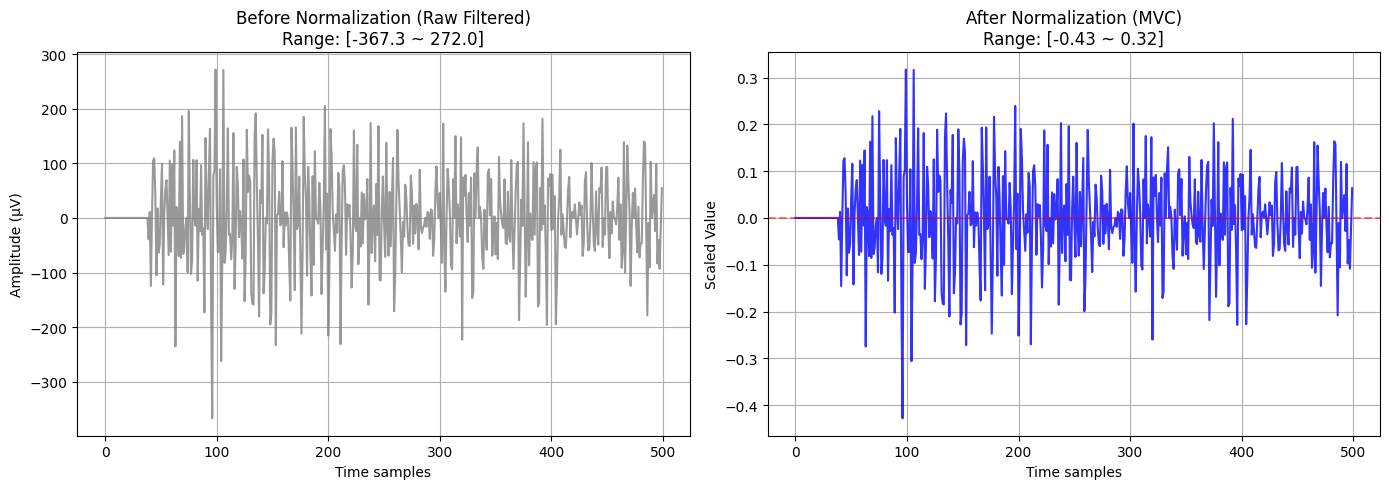

확인: 데이터의 패턴(모양)은 그대로 유지되면서, Y축 값의 범위만 변함.


In [9]:
import matplotlib.pyplot as plt

# 1. 비교할 데이터 선택 (첫 번째 학습 파일)
example_df = train_dfs[0]
raw_data = example_df['Ch1'].values[:500] # 앞부분 500개 샘플만 (2.5초)

# 2. 정규화 적용 (현재 선택된 SCALER_TYPE에 맞춰 변환)
# 주의: scaler_obj는 Step 4에서 학습된 'scaler' 변수여야 합니다.
# apply_normalization 함수는 Step 4에서 정의한 것을 그대로 씁니다.
# (함수가 정의되어 있지 않다면 아래 주석을 참고하여 직접 변환하세요)
norm_data_all = apply_normalization(example_df[target_channels].values, scaler)
norm_data_ch1 = norm_data_all[:500, 0] # Ch1에 해당하는 첫 번째 열만 가져옴

# 3. 그래프 그리기
plt.figure(figsize=(14, 5))

# (왼쪽) 정규화 전 - 원본(필터링만 된 상태)
plt.subplot(1, 2, 1)
plt.plot(raw_data, color='gray', alpha=0.8)
plt.title(f"Before Normalization (Raw Filtered)\nRange: [{raw_data.min():.1f} ~ {raw_data.max():.1f}]")
plt.xlabel("Time samples")
plt.ylabel("Amplitude (μV)")
plt.grid(True)

# (오른쪽) 정규화 후
plt.subplot(1, 2, 2)
plt.plot(norm_data_ch1, color='blue', alpha=0.8)
plt.title(f"After Normalization ({SCALER_TYPE})\nRange: [{norm_data_ch1.min():.2f} ~ {norm_data_ch1.max():.2f}]")
plt.xlabel("Time samples")
plt.ylabel("Scaled Value")
plt.axhline(0, color='red', linestyle='--', alpha=0.5) # 0 기준선
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"확인: 데이터의 패턴(모양)은 그대로 유지되면서, Y축 값의 범위만 변함.")


step5.Windowing

In [10]:
def create_windows_from_list(df_list, scaler_obj, window_size=40, overlap=20):
    X_list = []
    y_list = []
    step = window_size - overlap

    for df in df_list:
        # 여기서 아까 학습한 scaler_obj를 사용해 데이터를 실제로 변환합니다!
        raw_vals = df[target_channels].values
        data_norm = apply_normalization(raw_vals, scaler_obj)   # <---  변환 발생

        labels = df['label'].values

        if len(data_norm) < window_size:
            continue

        for i in range(0, len(data_norm) - window_size + 1, step):
            window_data = data_norm[i : i + window_size]
            window_label = labels[i + window_size - 1]

            X_list.append(window_data)
            y_list.append(window_label)

    return np.array(X_list), np.array(y_list)

In [11]:
# 실행
X_train, y_train = create_windows_from_list(train_dfs, scaler, window_size=40, overlap=20)
X_test, y_test = create_windows_from_list(test_dfs, scaler, window_size=40, overlap=20)

# 라벨값 조정 (1~5 -> 0~4)
y_train = y_train - 1
y_test = y_test - 1

print(f" -> Train Data Shape: X={X_train.shape}, y={y_train.shape}")
print(f" -> Test Data Shape : X={X_test.shape}, y={y_test.shape}")


 -> Train Data Shape: X=(14730, 40, 4), y=(14730,)
 -> Test Data Shape : X=(1461, 40, 4), y=(1461,)


LV5(실패지점 class) 제외하기

In [12]:
# ===========================================================
# [수정] Lv5 (Label 4) 데이터 제거하기
# ===========================================================
# 현재 라벨은 0~4 (Lv1~Lv5)로 되어 있습니다.
# 여기서 '4' (Lv5)인 데이터를 찾아서 제외합니다.

print(f"제거 전 데이터 개수: {len(y_train)}")

# 1. Train 데이터 필터링
mask_train = y_train < 4  # 0, 1, 2, 3만 True (4는 False)
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# 2. Test 데이터 필터링
mask_test = y_test < 4
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print(f"Lv5 제거 후 Train 개수: {len(y_train)}")
print(f"Lv5 제거 후 Test 개수: {len(y_test)}")


제거 전 데이터 개수: 14730
Lv5 제거 후 Train 개수: 14523
Lv5 제거 후 Test 개수: 1449


으아아아아아아 일단 전처리(노이즈 제거 + 센서 때진 부분 0으로 처리 + 정규화) 끝

step6. AI model formation (1D-CNN)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
# 1. 모델 구조 정의
input_shape = (40, 4)  # (Window_Size, Channels)
num_classes = 4        # 0,1,2,3,4 (총 5단계) 에서 0,1,2,3 총 4단계

model = Sequential([
    # Layer 1
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    tf.keras.layers.ELU(), # ReLU -> ELU 교체
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Layer 2
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.ELU(),#
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Layer 3
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.ELU(), #
    MaxPooling1D(pool_size=2),
    Dropout(0.3),


    # Fully Connected Layer (Classifier)
    Flatten(),
    Dense(256),
    tf.keras.layers.ELU(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # 최종 출력 (확률값)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# 2. 컴파일 (Compile)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,852 (1.74 MB)

 Trainable params: 453,956 (1.73 MB)

 Non-trainable params: 896 (3.50 KB)

In [16]:
from sklearn.utils import shuffle

# 3-1) 학습 전에 데이터 뒤섞기
X_train, y_train = shuffle(X_train, y_train, random_state=42)
print("데이터 셔플링 완료")


데이터 셔플링 완료


In [17]:
# 3. 학습 시작 (Training)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)


Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.2723 - loss: 2.3850 - val_accuracy: 0.2172 - val_loss: 1.4091 - learning_rate: 5.0000e-04
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2943 - loss: 1.6748 - val_accuracy: 0.2238 - val_loss: 1.5082 - learning_rate: 5.0000e-04
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2980 - loss: 1.5582 - val_accuracy: 0.2840 - val_loss: 1.3803 - learning_rate: 5.0000e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3337 - loss: 1.4683 - val_accuracy: 0.3590 - val_loss: 1.3461 - learning_rate: 5.0000e-04
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3341 - loss: 1.4163 - val_accuracy: 0.3869 - val_loss: 1.3129 - learning_rate: 5.0000e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3507 - loss: 1.3735 - val_accuracy: 0.3883 - val_loss: 1.3011 - learning_rate: 5.0000e-04
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

step7. evaluation

★ Final Test Accuracy: 32.51%


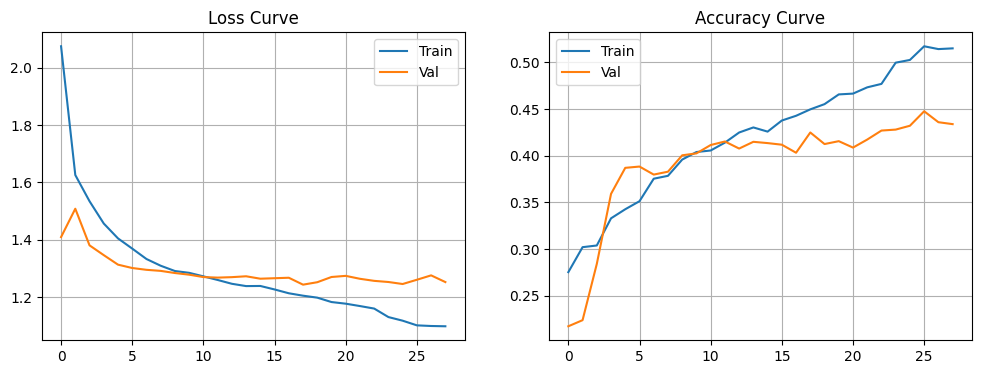

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


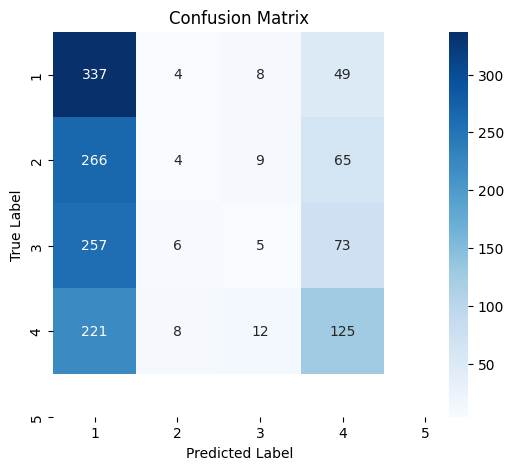


Classification Report:
              precision    recall  f1-score   support

         Lv1       0.31      0.85      0.46       398
         Lv2       0.18      0.01      0.02       344
         Lv3       0.15      0.01      0.03       341
         Lv4       0.40      0.34      0.37       366

    accuracy                           0.33      1449
   macro avg       0.26      0.30      0.22      1449
weighted avg       0.26      0.33      0.23      1449



In [18]:
# 1. 정확도 평가
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"★ Final Test Accuracy: {test_acc*100:.2f}%")

# 2. 학습 그래프 (Loss & Accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# 3. 혼동 행렬 (Confusion Matrix)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Lv1', 'Lv2', 'Lv3', 'Lv4'])) # LV5 제외

step8. 실제 1D_CNN 예측 라벨값과 실제 라벨값 비교

Test Files: ['/content/drive/MyDrive/Colab Notebooks/sEMG_data_test/sEMG_data_26.csv', '/content/drive/MyDrive/Colab Notebooks/sEMG_data_test/sEMG_data_27.csv']
--- Processing Test File 1 Files (1 files) ---
[1/1] Filtering Completed: sEMG_data_26.csv


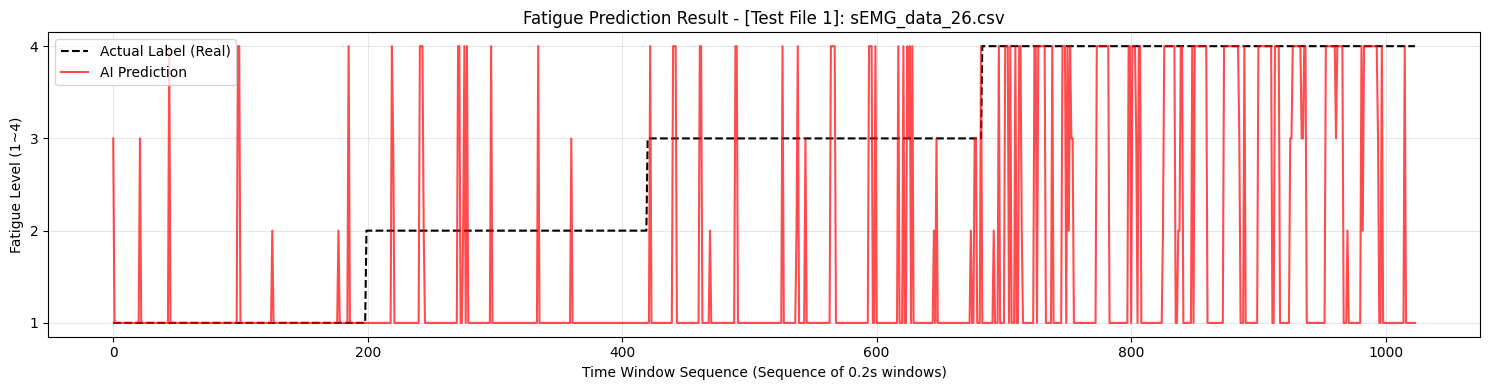

 -> [Test File 1] Accuracy: 31.54% (1024 windows)

--- Processing Test File 2 Files (1 files) ---
[1/1] Filtering Completed: sEMG_data_27.csv


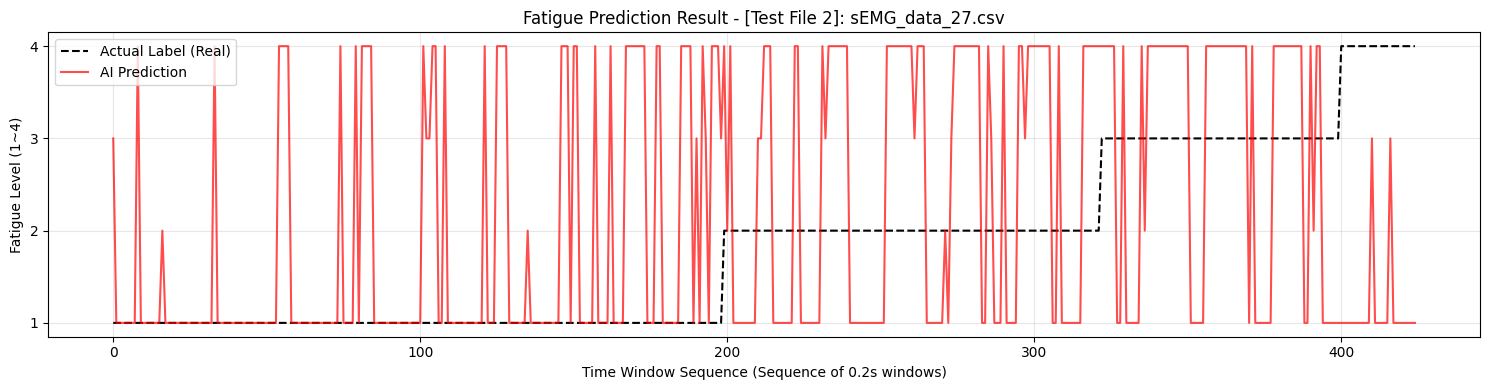

 -> [Test File 2] Accuracy: 34.82% (425 windows)



In [19]:
# 1. 테스트 데이터를 파일별로 다시 처리 (시각화를 위해 순서대로 윈도우 생성)
# (주의: 섞이지 않은 순수한 시계열 순서를 유지해야 함)

# 테스트 파일 리스트 다시 확인
print(f"Test Files: {all_test_files}")

# 그래프 그리기 반복문
for i, test_file_path in enumerate(all_test_files):
    # A. 파일 하나만 따로 로드 및 전처리
    # (이미 만들어둔 함수들을 재활용합니다)
    temp_dfs = process_and_filter_files([test_file_path], purpose=f"Test File {i+1}")

    # B. Windowing (Lv5 제거 포함)
    X_temp, y_temp = create_windows_from_list(temp_dfs, scaler, window_size=40, overlap=20)
    y_temp = y_temp - 1 # 1~5 -> 0~4

    # Lv5 (Label 4) 제거
    mask = y_temp < 4
    X_temp = X_temp[mask]
    y_temp = y_temp[mask]

    if len(X_temp) == 0:
        print(f" -> 파일 {i+1}에 Lv1~4 데이터가 없습니다. Skip.")
        continue

    # C. 모델 예측
    # (학습된 model 변수가 메모리에 있어야 함)
    pred_probs = model.predict(X_temp, verbose=0)
    y_pred_temp = np.argmax(pred_probs, axis=1)

    # D. 그래프 그리기
    plt.figure(figsize=(15, 4))

    # 실제값 (검은색 점선)
    plt.plot(y_temp + 1, color='black', linestyle='--', linewidth=1.5, label='Actual Label (Real)')

    # 예측값 (빨간색 실선)
    # (보기 좋게 약간 투명도 줌)
    plt.plot(y_pred_temp + 1, color='red', alpha=0.7, linewidth=1.5, label='AI Prediction')

    plt.title(f"Fatigue Prediction Result - [Test File {i+1}]: {test_file_path.split('/')[-1]}")
    plt.xlabel('Time Window Sequence (Sequence of 0.2s windows)')
    plt.ylabel('Fatigue Level (1~4)')
    plt.yticks([1, 2, 3, 4]) # Y축 눈금 정수만 표시
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 정확도도 같이 출력해주면 좋음
    acc = np.mean(y_temp == y_pred_temp)
    print(f" -> [Test File {i+1}] Accuracy: {acc*100:.2f}% ({len(y_temp)} windows)\n")
